In [68]:
from pathlib import Path
import torch
from IRS.networks.DispNetC import DispNetC

EXP_NAME = 'per_loss'
CKPT_DIR = Path(f'ckpts/{EXP_NAME}')
RESULTS_DIR = Path(f'results/{EXP_NAME}')
# PRETRAIN_CHECKPOINT = CKPT_DIR / "dispnet_epoch_3"
PRETRAIN_CHECKPOINT = None
DEVICE = 'cuda:0'

def get_best_model(ckpt_dir: Path):
    best_EPE, best_model = 1000, None
    for ckpt_f in ckpt_dir.iterdir():
        ckpt = torch.load(ckpt_f, map_location = DEVICE)
        if ckpt['epe'] < best_EPE:
            best_model = ckpt['model']
            best_EPE = ckpt['epe']
    return best_model


net = DispNetC(batchNorm=False, input_channel=3, maxdisp=194).to(DEVICE)
if PRETRAIN_CHECKPOINT is None:
    net.load_state_dict(get_best_model(CKPT_DIR))
else:
    net.load_state_dict(torch.load(PRETRAIN_CHECKPOINT, map_location = DEVICE)['model'])
net.eval()


/project/IRS/networks/DispNetC.py:117: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  kaiming_normal(m.weight.data)


DispNetC(
  (relu): ReLU()
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): LeakyReLU(negative_slope=0.1, inplace=True)
  )
  (conv2): ResBlock(
    (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (shortcut): Sequential(
      (0): Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (conv3): ResBlock(
    (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (

/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:3631: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


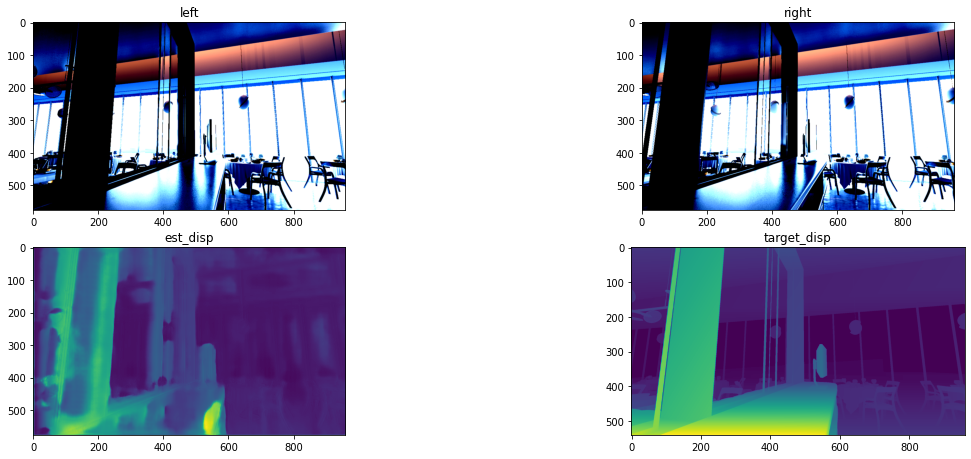

In [69]:
from IRS.dataloader.IRSLoader import IRSDataset
import torch.nn.functional as F
import matplotlib.pyplot as plt

DATASET = 'IRS/lists/Restaurant_TRAIN.list'
METAL_DATASET = 'IRS/lists/IRS_restaurant_metal_test.list'
test_dataset = IRSDataset(txt_file=METAL_DATASET, root_dir="/data", phase='test', load_norm=False)
# good: 8, 12, 15, 26
sample = test_dataset[15]
left_input = sample["img_left"].to(DEVICE).unsqueeze(0)
right_input = sample["img_right"].to(DEVICE).unsqueeze(0)
left_input = F.interpolate(left_input, test_dataset.scale_size, mode="bilinear")
right_input = F.interpolate(right_input, test_dataset.scale_size, mode="bilinear")
input = torch.cat((left_input, right_input), 1)
with torch.no_grad():
    disp = net(input)[0]
target_disp = sample["gt_disp"].to(DEVICE)

fig = plt.figure(figsize=(20,20))
ax1 = fig.add_subplot(5,2,1)
plt.title('left')
ax1.imshow(left_input[0].cpu().moveaxis(0, -1))
ax2 = fig.add_subplot(5,2,2)
plt.title('right')
ax2.imshow(right_input[0].cpu().moveaxis(0, -1))
ax3 = fig.add_subplot(5,2,3)
plt.title('est_disp')
ax3.imshow(disp[0].cpu().moveaxis(0, -1))
ax3 = fig.add_subplot(5,2,4)
plt.title('target_disp')
ax3.imshow(target_disp[0].cpu())


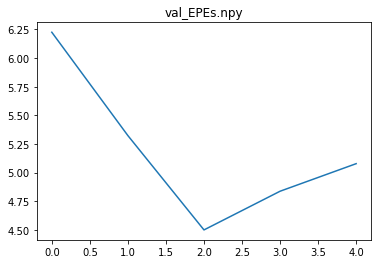

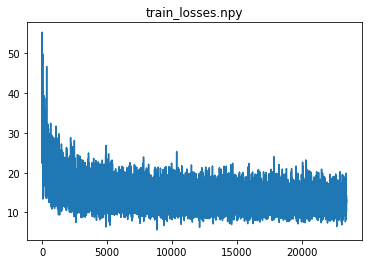

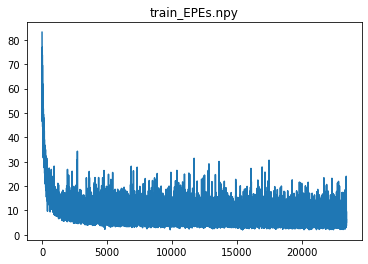

In [70]:
import numpy as np

for result_f in RESULTS_DIR.iterdir():
    results = np.load(result_f)
    plt.figure()
    plt.plot(results)
    plt.title(result_f.name)